In [143]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("seaborn")
import requests
from pyproj import Proj, transform
import tqdm
import concurrent.futures
import requests
import time
import shapefile
import fiona
from shapely.geometry import shape,mapping, Point, Polygon, MultiPolygon
import geopandas
import fiona
import rtree

# Load data

In [134]:
boucherville_2013 = pd.read_csv("data/OD13_amtSm_309.csv")
longueuilEst_2013 = pd.read_csv("data/OD13_amtSm_302.csv")
saintBruno_2013 = pd.read_csv("data/OD13_amtSm_310.csv")
#suburb = pd.concat([boucherville_2013, longueuilEst_2013, saintBruno_2013])
suburb_2013 = pd.read_csv("data/OD13_suburb_with_walkscore_and_trip_osrm.csv")
suburb_2013.title = "Banlieue 2013"

boucherville_2003 = pd.read_csv("data/OD03_amtSm_309.csv")
longueuilEst_2003 = pd.read_csv("data/OD03_amtSm_302.csv")
saintBruno_2003 = pd.read_csv("data/OD03_amtSm_310.csv")
#suburb_2003 = pd.concat([boucherville_2003, longueuilEst_2003, saintBruno_2003])
suburb_2003 = pd.read_csv("data/OD03_suburb_with_od_trips.csv")
suburb_2003.title = "Banlieue 2003"

#montrealNord = pd.read_csv("data/OD13_amtSm_118.csv")
montrealNord = pd.read_csv("data/OD13_montrealNord_od_trips.csv")
montrealNord.title = "Montréal-Nord"

#plateau = pd.read_csv("data/OD13_amtSm_106.csv")
plateau = pd.read_csv("data/OD13_plateau_with_od_trips.csv")
plateau.title = "Le Plateau Mont-Royal"

EPOI_2013_Boucherville = pd.read_csv("data/EPOI2013Sm_309.csv")

da_density = pd.read_csv("data/T1901EN.CSV", encoding="cp1252", usecols=["Geographic code", "Population density per square kilometre, 2016"])
da_density.columns = ['geographic_code', 'density']
da_density.set_index('geographic_code', inplace=True)

da_shapefile = fiona.open('data/lda_000b16a_e.shp')


In [153]:
# Create the R-tree index and store the features in it (bounding box)
spatial_index = rtree.index.Index()
for pos, poly in tqdm.tqdm(enumerate(da_shapefile)):
    spatial_index.insert(pos, shape(poly['geometry']).bounds)

56589it [00:20, 2822.45it/s]


In [4]:
# NAD 83 to lat long
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:32188", "epsg:4326", always_xy=True)

## WalkScore

In [5]:
exit_early = True

In [6]:
def load_url(url, feuillet_id, timeout=20):
    ans = requests.get(url, timeout=timeout)
    json_output = ans.json()
    #json_output = {"walkscore": feuillet_id}
    return feuillet_id, ans, json_output

def calculate_walk_score(df, exit_early=True):
    futures = []
    
    if exit_early:
        return
    warning = input("Warning!!! Are you sure ? ").lower()

    if warning != "y":
        print("bye")
        return

    feuillet_ids = df.feuillet.unique()
    with tqdm.tqdm(total=len(feuillet_ids)) as progress_bar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=9) as executor:
            for feuillet_id in feuillet_ids:                
                x_domi = (df[df.feuillet == feuillet_id].xdomi).iloc[0]
                y_domi = (df[df.feuillet == feuillet_id].ydomi).iloc[0]
                x_domi, y_domi = transformer.transform(int(x_domi), int(y_domi))
                rows = df[df.feuillet == feuillet_id]
                url = f"https://api.walkscore.com/score?format=json&transit=1&bike=1&lon={x_domi}&lat={y_domi}&wsapikey=2845bc34690754d7389df25eabeb8ce9"
                #url = "https://jsonplaceholder.typicode.com/todos/1"
                futures.append(executor.submit(load_url, url, feuillet_id))

            for future in concurrent.futures.as_completed(futures):
                feuillet_id, ans, json_resp = future.result()
                if ans.status_code != 200:
                    print(f"{feuillet_id}, {json_resp}")

                walk_score = json_resp.get("walkscore", -1)
                bike_score = json_resp.get("bike", {}).get("score", -1)
                transit_score = json_resp.get("transit", {}).get("score", -1)

                # Store the data
                df.loc[df.feuillet == feuillet_id, 'walkscore'] = walk_score
                df.loc[df.feuillet == feuillet_id, 'bikescore'] = bike_score
                df.loc[df.feuillet == feuillet_id, 'transitscore'] = transit_score

                progress_bar.update(1)


In [7]:
calculate_walk_score(suburb_2013, exit_early=exit_early)
#suburb.to_csv("data/OD13_suburb_with_walkscore.csv")

In [8]:
calculate_walk_score(montrealNord, exit_early=exit_early)
#montrealNord.to_csv("data/OD13_montrealNord_with_walkscore.csv")

In [9]:
calculate_walk_score(plateau, exit_early=exit_early)
#plateau.to_csv("data/OD13_plateau_with_walkscore.csv")

# Trip lengths (OSRM)

In [299]:
def load_url_osrm(url, ipere, timeout=20):
    ans = requests.get(url, timeout=timeout)
    json_output = ans.json()
    return ipere, ans, json_output


def calculate_trip_length(df, exit_early=True):
    futures = []
    
    if exit_early:
        return
    warning = input("Warning!!! Are you sure ? ").lower()

    if warning != "y":
        print("bye")
        return

    with tqdm.tqdm(total=len(df)) as progress_bar:
        with concurrent.futures.ThreadPoolExecutor(max_workers=9) as executor:
            for i, row in df.iterrows():

                x_orig, y_orig = transformer.transform(int(row.xorig), int(row.yorig))
                x_dest, y_dest = transformer.transform(int(row.xdest), int(row.ydest))

                url = f"http://localhost:5000/route/v1/driving/{x_orig},{y_orig};{x_dest},{y_dest}?overview=false&geometries=geojson"
                futures.append(executor.submit(load_url_osrm, url, row.ipere))

            for future in concurrent.futures.as_completed(futures):
                ipere, ans, json_resp = future.result()
                #print(json_resp)
                if ans.status_code != 200 or json_resp['code'] != "Ok":
                    print(f"{ipere}, {json_resp}")
                #print(json_resp)
                distance_meters = json_resp['routes'][0]['distance']
                duration_seconds = json_resp['routes'][0]['duration']
                
                df.loc[df.ipere == ipere, 'distance_meters'] = distance_meters
                df.loc[df.ipere == ipere, 'duration_seconds'] = duration_seconds

                # Store the data
                #df.loc[df.feuillet == feuillet_id, 'walkscore'] = walk_score
                #df.loc[df.feuillet == feuillet_id, 'bikescore'] = bike_score
                #df.loc[df.feuillet == feuillet_id, 'transitscore'] = transit_score

                progress_bar.update(1)



In [300]:
#calculate_trip_length(suburb_2013, exit_early=False)
#suburb_2013.to_csv("data/OD13_suburb_with_walkscore_and_trip_osrm.csv")
#calculate_trip_length(suburb_2003, exit_early=False)
#suburb_2003.to_csv("data/OD03_suburb_with_od_trips.csv")
#calculate_trip_length(plateau, exit_early=False)
#plateau.to_csv("data/OD13_plateau_with_odtrips.csv")
#calculate_trip_length(montrealNord, exit_early=False)
#montrealNord.to_csv("data/OD13_montrealNord_with_odtrips.csv")

Warning!!! Are you sure ? y


100%|████████████████████████████████████| 10369/10369 [01:07<00:00, 154.74it/s]


Warning!!! Are you sure ? y


100%|██████████████████████████████████████| 7659/7659 [00:44<00:00, 172.25it/s]


In [303]:
plateau.trip_length

AttributeError: 'DataFrame' object has no attribute 'trip_length'

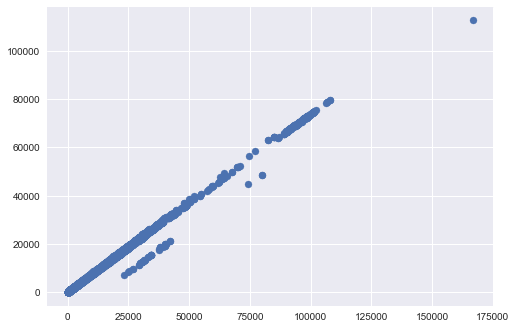

In [12]:
plt.scatter(suburb_2013.distance_meters, suburb_2013.duration_seconds)

# Densities

In [185]:
def calculate_density(df):
    transformer2 = Transformer.from_crs("epsg:32188", "epsg:3347", always_xy=True)
    households = df[df.f_menage == "T"]
    for i, row in tqdm.tqdm(households.iterrows()):
        point = Point(transformer2.transform(row.xdomi, row.ydomi))
        for j in spatial_index.intersection(point.coords[0]):
            if point.within(shape(da_shapefile[j]['geometry'])):
                dauid = int(da_shapefile[j]['properties']['DAUID'])
                density = da_density.loc[dauid][0]
                df.loc[df.feuillet == row.feuillet, 'density'] = density
                break
        else:
            print("could not find")

In [187]:
calculate_density(suburb_2013)
calculate_density(suburb_2003)
calculate_density(montrealNord)
calculate_density(plateau)

2366it [00:02, 817.16it/s]
1897it [00:04, 473.07it/s]
1475it [00:02, 649.91it/s]
1946it [00:03, 579.91it/s]


# Typologies

## Personnes

In [272]:
def pers_typology(df, typology_number):
    if typology_number == 1:   # Typologie 1: femmes, 20-39 ans, étudiantes
        return df[(df.genre == 2)
            & (df.age >= 20)
            & (df.age <= 39)
            & (df.p_statut == 3)]
    elif typology_number == 2: # Typologie 2: femmes, 20-39 ans, travailleuses à temps plein
        return df[(df.genre == 2)
            & (df.age >= 20)
            & (df.age <= 39)
            & (df.p_statut == 1)]
    elif typology_number == 3: # Typologie 3: hommes, 20-39 ans, étudiants
        return df[(df.genre == 1) 
            & (df.age >= 20) 
            & (df.age <= 39)
            & (df.p_statut == 3)]
    elif typology_number == 4: # Typologie 4: hommes, 20-39 ans, travailleurs à temps plein
        return df[(df.genre == 1) 
            & (df.age >= 20) 
            & (df.age <= 39)
            & (df.p_statut == 1)]
    elif typology_number == 5: # Typologie 5: Hommes, 50-69 ans, retraités
        return df[(df.genre == 1) 
            & (df.age >= 50) 
            & (df.age <= 69)
            & (df.p_statut == 4)]
    elif typology_number == 6: # Typologie 6: Hommes, 50-69 ans, travailleurs à temps plein
        return df[(df.genre == 1) 
            & (df.p_statut == 1)
            & (df.age >= 50) 
            & (df.age <= 69)
        ]

In [273]:
def calculate_pers_typology_obs_size(df):
    print(f"=== {df.title} ===")
    # Make sure this is only the people DB
    df_ = df[df["f_pers"] == 'T']
    
    for i in [1, 2, 3, 4, 5, 6]:
        facper_share = pers_typology(df_, i).facper.sum() / df_.facper.sum()
        df_typology = pers_typology(df_, i)
        print(f"Typologie {i}: {len(df_typology)}, {(len(df_typology) / len(df_)) * 100:0.2f}%, facper: {facper_share * 100:0.2f} %")

In [274]:
calculate_pers_typology_obs_size(suburb_2013)
calculate_pers_typology_obs_size(suburb_2003)
calculate_pers_typology_obs_size(montrealNord)
calculate_pers_typology_obs_size(plateau)

=== Banlieue 2013 ===
Typologie 1: 108, 1.86%, facper: 2.33 %
Typologie 2: 288, 4.96%, facper: 6.66 %
Typologie 3: 116, 2.00%, facper: 2.61 %
Typologie 4: 327, 5.63%, facper: 7.89 %
Typologie 5: 349, 6.01%, facper: 4.47 %
Typologie 6: 525, 9.04%, facper: 8.15 %
=== Banlieue 2003 ===
Typologie 1: 90, 1.91%, facper: 2.09 %
Typologie 2: 368, 7.82%, facper: 8.20 %
Typologie 3: 80, 1.70%, facper: 1.88 %
Typologie 4: 419, 8.90%, facper: 9.48 %
Typologie 5: 205, 4.36%, facper: 4.26 %
Typologie 6: 326, 6.93%, facper: 6.41 %
=== Montréal-Nord ===
Typologie 1: 83, 2.46%, facper: 3.06 %
Typologie 2: 151, 4.48%, facper: 5.52 %
Typologie 3: 51, 1.51%, facper: 2.13 %
Typologie 4: 202, 6.00%, facper: 7.89 %
Typologie 5: 139, 4.13%, facper: 3.15 %
Typologie 6: 194, 5.76%, facper: 5.18 %
=== Le Plateau Mont-Royal ===
Typologie 1: 127, 3.24%, facper: 6.01 %
Typologie 2: 318, 8.10%, facper: 12.76 %
Typologie 3: 114, 2.91%, facper: 4.66 %
Typologie 4: 385, 9.81%, facper: 16.34 %
Typologie 5: 165, 4.20%, f

## Ménages

In [275]:
def add_children_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        children_count = len(people_in_household[people_in_household.age <= 17])
        df.loc[df.feuillet == feuillet_id, 'children'] = children_count
    df['children'] = df['children'].astype(int)
def add_drivers_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        drivers_count = len(people_in_household[people_in_household.permis == 1])
        df.loc[df.feuillet == feuillet_id, 'drivers'] = drivers_count

    df['drivers'] = df['drivers'].astype(int)
def add_retired_column(df):
    for feuillet_id in df.feuillet.unique():
        rows = df[df.feuillet == feuillet_id]
        people_in_household = rows[rows.f_pers == "T"]
        retired_count = len(people_in_household[people_in_household.p_statut == 4])
        df.loc[df.feuillet == feuillet_id, 'retired'] = retired_count
    df['retired'] = df['retired'].astype(int)
#def add_trip_distance_column(df): # TODO: Remplacer par calcul de chemin avec OSRM !
#    df['trip_distance'] = np.sqrt((df.xdest - df.xorig) **2 + (df.ydest - df.yorig)**2)

for df in tqdm.tqdm([suburb_2013, suburb_2003, montrealNord, plateau]):
    add_children_column(df)
    add_drivers_column(df)
    add_retired_column(df)
    #add_trip_distance_column(df)


100%|█████████████████████████████████████████████| 4/4 [00:33<00:00,  8.40s/it]


In [276]:
def menages_typology(df, typology):
    if typology == 1: # Typologie 1: min 1 enfant, pas d'automobiles
        return df[(df.children >= 1)
                & (df.autologi == 0)
                ]
    elif typology == 2: # Typologie 2: 4+ logis, 2 enfants+, 2 autos+
        return df[(df.perslogi >= 2)
                & (df.children >= 2)
                & (df.autologi >= 2)
                ]
    elif typology == 3: # Typologie 3: Full car access : Nb drivers = Nb automobiles
        return df[(df.autologi == df.drivers)
                & (df.autologi >= 1)
                ]
    elif typology == 4: # Typologie 4: More cars than drivers
        return df[(df.autologi > df.drivers)
                ]
    elif typology == 5: # Typologie 5: Couples sans enfants (ou colocataires)
        return df[(df.children == 0)
                & (df.perslogi == 2)
                ]
    elif typology == 6: # Typologie 6: Couple de retraités ayant chacun un permis de conduire
        return df[(df.perslogi == 2)
                & (df.retired == 2)
                & (df.drivers == 2)
                ]

In [277]:
def calculate_household_typology_obs_size(df):
    print(f"=== {df.title} ===")
    # Make sure this is only the household DB
    df_ = df[df["f_menage"] == 'T']
    
    for i in [1, 2, 3, 4, 5, 6]:
        fshare = menages_typology(df_, i).faclog.sum() / df_.faclog.sum()
        print(f"Typologie {i}: {len(menages_typology(df_, i))} {round(fshare * 100, 2):0.2f} %")

In [278]:
calculate_household_typology_obs_size(suburb_2013)
calculate_household_typology_obs_size(montrealNord)
calculate_household_typology_obs_size(plateau)

=== Banlieue 2013 ===
Typologie 1: 12 0.53 %
Typologie 2: 288 11.26 %
Typologie 3: 1415 60.96 %
Typologie 4: 146 6.39 %
Typologie 5: 989 35.21 %
Typologie 6: 352 11.59 %
=== Montréal-Nord ===
Typologie 1: 54 4.00 %
Typologie 2: 68 4.55 %
Typologie 3: 697 46.87 %
Typologie 4: 59 4.25 %
Typologie 5: 461 27.03 %
Typologie 6: 87 4.60 %
=== Le Plateau Mont-Royal ===
Typologie 1: 106 3.91 %
Typologie 2: 23 0.66 %
Typologie 3: 591 31.28 %
Typologie 4: 40 2.14 %
Typologie 5: 571 29.01 %
Typologie 6: 46 1.82 %


## Voisinages

count    32570.000000
mean      8932.534949
std       7037.247095
min          0.000000
25%       3022.700000
50%       6920.100000
75%      13984.700000
max      45392.900000
Name: density, dtype: float64

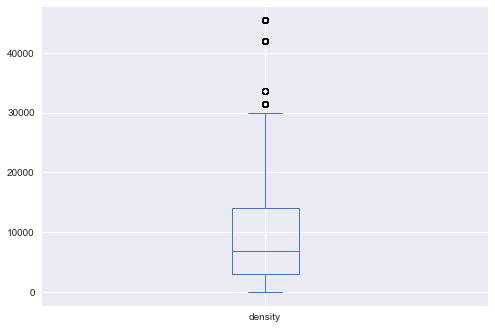

In [218]:
all_densities = pd.concat([suburb_2013.density, montrealNord.density, plateau.density])
all_densities.plot.box()
all_densities.describe()

count    32570.000000
mean        56.575100
std         28.836868
min          0.000000
25%         33.000000
50%         58.000000
75%         87.000000
max         98.000000
Name: walkscore, dtype: float64

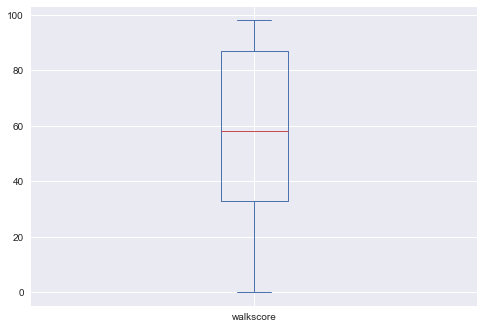

In [219]:
all_walkscores = pd.concat([suburb_2013.walkscore, montrealNord.walkscore, plateau.walkscore])
all_walkscores.plot.box()
all_walkscores.describe()

In [279]:
def neighborhood_typology(df, typology):
    if typology == 1: 
        return df[(df.walkscore < all_walkscores.quantile(.25))
                & (df.density < all_densities.quantile(.25))
                ]
    elif typology == 2:
        return df[(df.walkscore >= all_walkscores.quantile(.25))
                & (df.walkscore < all_walkscores.quantile(.50))
                & (df.density >= all_densities.quantile(.25))
                & (df.density < all_densities.quantile(.50))
                ]
    elif typology == 3:
        return df[(df.walkscore >= all_walkscores.quantile(.50))
                & (df.walkscore < all_walkscores.quantile(.75))
                & (df.density >= all_densities.quantile(.50))
                & (df.density < all_densities.quantile(.75))
                ]
    elif typology == 4:
        return df[(df.walkscore >= all_walkscores.quantile(.75))
                & (df.walkscore < all_walkscores.quantile(1))
                & (df.density >= all_densities.quantile(.75))
                & (df.density < all_densities.quantile(1))
                ]

In [280]:
def calculate_neighborhood_typology_obs_size(df):
    print(f"=== {df.title} ===")
    # Make sure this is only the household DB
    df_ = df[df["f_menage"] == 'T']
    
    for i in [1, 2, 3, 4]:
        fshare = neighborhood_typology(df_, i).faclog.sum() / df_.faclog.sum()
        print(f"Typologie {i}: {len(menages_typology(df_, i))} {round(fshare * 100, 2):0.2f} %")

calculate_neighborhood_typology_obs_size(suburb_2013)
calculate_neighborhood_typology_obs_size(montrealNord)
calculate_neighborhood_typology_obs_size(plateau)

=== Banlieue 2013 ===
Typologie 1: 12 31.38 %
Typologie 2: 288 15.83 %
Typologie 3: 1415 2.98 %
Typologie 4: 146 0.00 %
=== Montréal-Nord ===
Typologie 1: 54 0.00 %
Typologie 2: 68 13.96 %
Typologie 3: 697 29.32 %
Typologie 4: 59 0.00 %
=== Le Plateau Mont-Royal ===
Typologie 1: 106 0.00 %
Typologie 2: 23 0.00 %
Typologie 3: 591 5.89 %
Typologie 4: 40 51.22 %


# Tâche #2

[10.37767562 12.50983111 10.80142697 11.41497875 14.8633178  16.33509275
 12.60862259  8.20242312  2.6569537   0.22967758]
[11.05167269 13.84339846 11.78566454 13.66042676 18.88124172 14.66641621
  9.66614158  4.79089681  1.46936289  0.18477835]


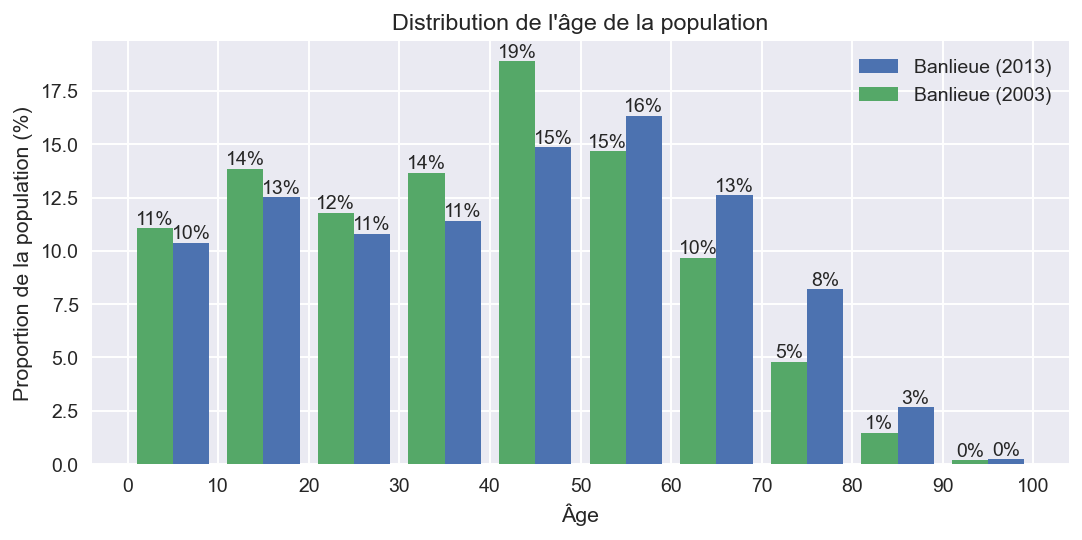

In [337]:
width = 4
plt.figure(figsize=(9, 4), dpi=140)
def age_plot(df, title, offset):
    df_people = df[df["f_pers"] == 'T']

    total_facper = df_people.facper.sum()

    age_bin_edges = np.array([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
    age_bins = np.histogram(list(df_people.age), bins=age_bin_edges, weights=df_people.facper / total_facper * 100)[0]
    print(age_bins)
    
    bar = plt.bar(age_bin_edges[:-1]-offset+5, age_bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(age_bin_edges)
    plt.xlabel("Âge")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de l'âge de la population")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()


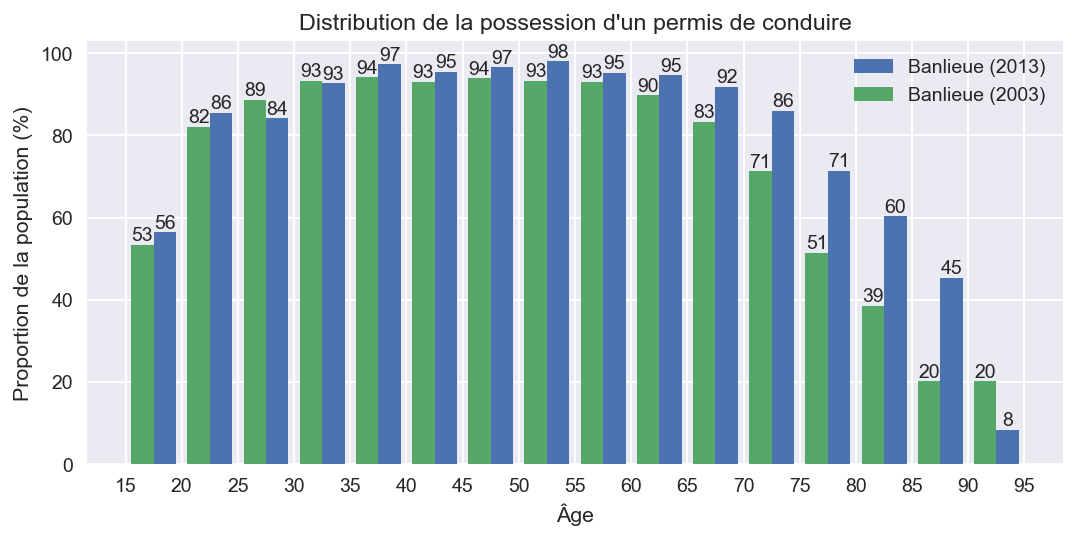

In [254]:
width = 2
plt.figure(figsize=(9, 4), dpi=140)
def drivers_plot(df, title, offset):
    bins = np.arange(15, 100, 5)
    df["age_cut"] = pd.cut(df["age"], bins)

    df_people = df[df["f_pers"] == 'T']
    drivers_rate = df_people[df_people["permis"] == 1].groupby("age_cut").sum()["facper"] / df_people.groupby("age_cut").sum()["facper"] * 100
    
    bar = plt.bar(bins[:-1]+2.5-offset, drivers_rate, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f")
    _ = plt.xticks(bins)
    plt.xlabel("Âge")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de la possession d'un permis de conduire")
drivers_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
drivers_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()


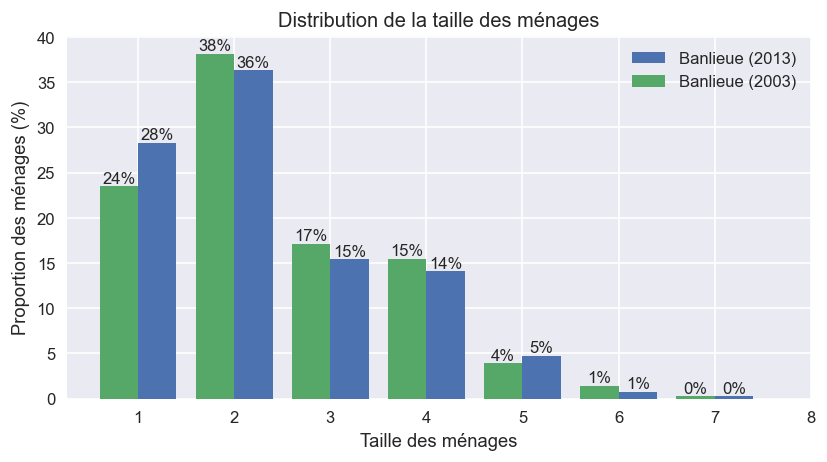

In [228]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([1, 2, 3, 4, 5, 6, 7, 8])
    bins = np.histogram(list(df_households.perslogi), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Taille des ménages")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution de la taille des ménages")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()



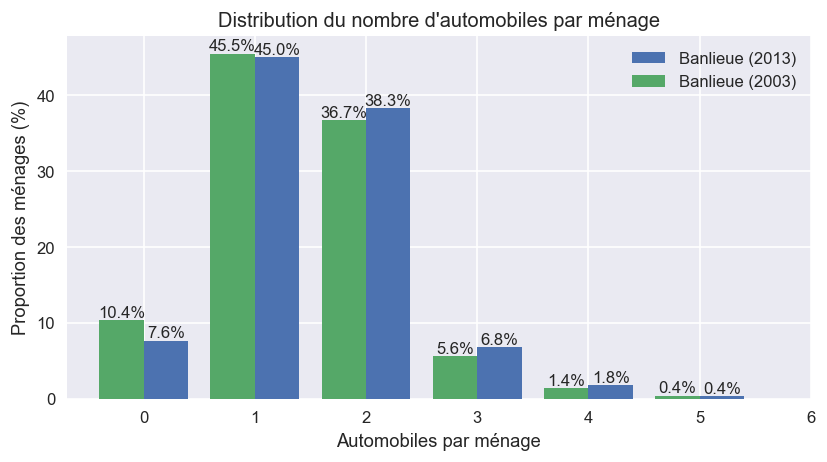

In [70]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([0, 1, 2, 3, 4, 5, 6])
    bins = np.histogram(list(df_households.autologi), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.1f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Automobiles par ménage")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution du nombre d'automobiles par ménage")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.legend()


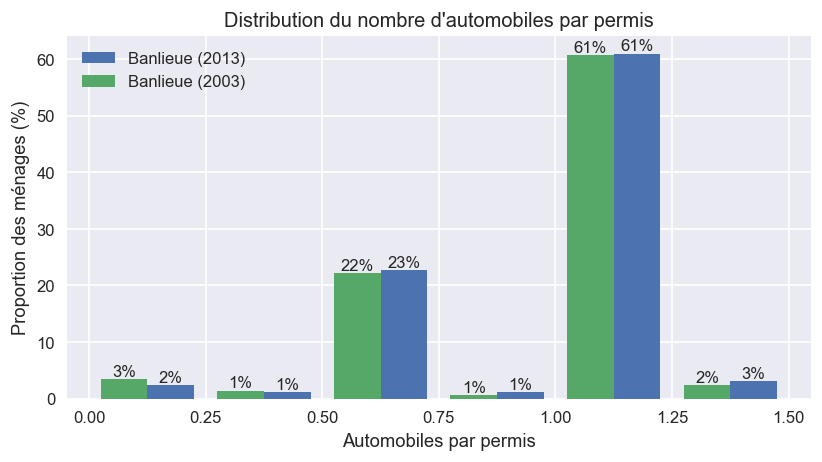

In [232]:
width = 0.10
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_households = df[df["f_menage"] == 'T']

    total_faclog = df_households.faclog.sum()

    bin_edges = np.array([0, 0.25, 0.50, 0.75, 1.00, 1.25, 1.5])
    bins = np.histogram(list(df_households.autologi / df_households.drivers), bins=bin_edges, weights=df_households.faclog / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset+0.125, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges)
    plt.xlabel("Automobiles par permis")
    plt.ylabel("Proportion des ménages (%)")
    plt.title("Distribution du nombre d'automobiles par permis")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.legend()



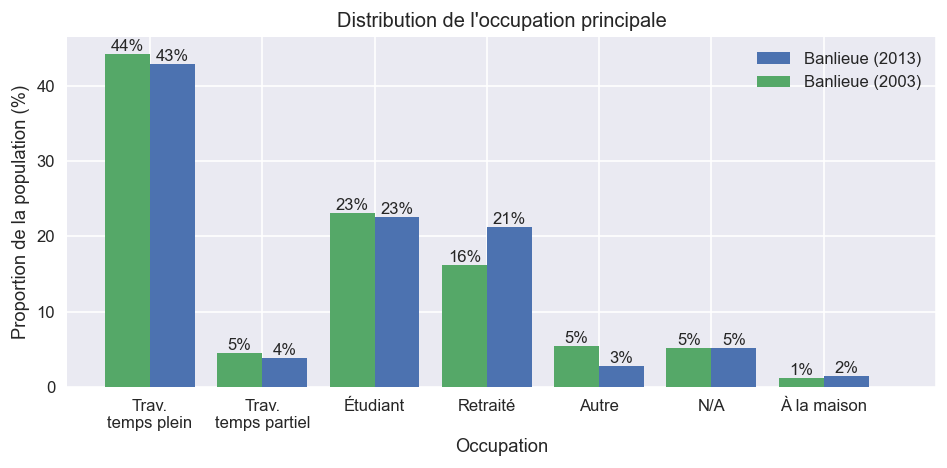

In [236]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def age_plot(df, title, offset):
    df_people = df[df["f_pers"] == 'T']

    total_facper = df_people.facper.sum()

    age_bin_edges = np.array([1, 2, 3, 4, 5, 6, 7, 8])
    age_bins = np.histogram(list(df_people.p_statut), bins=age_bin_edges, weights=df_people.facper / total_facper * 100)[0]
    
    bar = plt.bar(age_bin_edges[:-1]-offset, age_bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(age_bin_edges, ["Trav.\ntemps plein", "Trav.\ntemps partiel", "Étudiant", "Retraité", "Autre", "N/A", "À la maison", ""])
    plt.xlabel("Occupation")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution de l'occupation principale")
age_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
age_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()



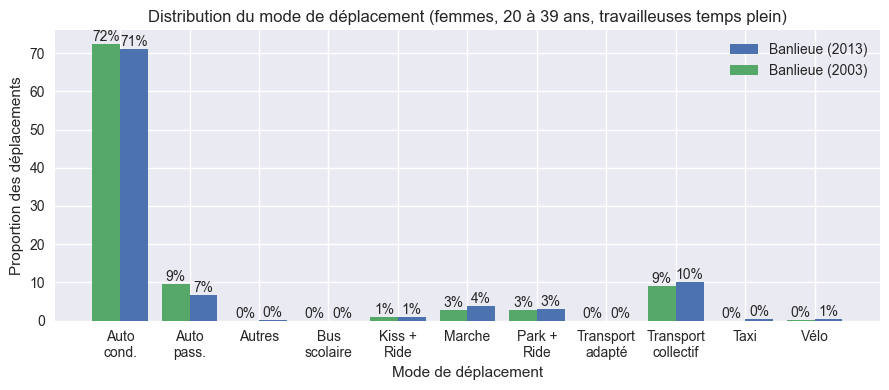

In [252]:
width = 0.4
plt.figure(figsize=(9, 4), dpi=100)
def _plot(df, title, offset):
    #df_chaines = df[df["f_chaine"] == 'T']
    df_chaines = df[(df.genre == 2)
            & (df.age >= 20)
            & (df.age <= 39)
            & (df.p_statut == 1)]
    
    total_facper = df_chaines.facper.sum()

    modes_ = (df_chaines.groupby("mode").sum()["facper"] / total_facper.sum() * 100)
    modes = []
    for mode in ["AC", "AP", "AUTRES", "BS", "KR", "MARCHE", "PR", "TA", "TC", "TX", "VELO"]:
        try:
            modes.append(modes_[mode])
        except KeyError:
            modes.append(0)
    modes = list(modes)
    xvals = np.arange(0, len(modes))
    bar = plt.bar(xvals-offset, modes, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(xvals, ["Auto\ncond.",
                            "Auto\npass.",
                            "Autres", 
                            "Bus\nscolaire",
                            "Kiss +\nRide",
                            'Marche',
                            "Park +\nRide",
                            'Transport\nadapté', 
                            "Transport\ncollectif",
                            'Taxi', 
                            "Vélo",
                           ])
    plt.xlabel("Mode de déplacement")
    plt.ylabel("Proportion des déplacements")
    plt.title("Distribution du mode de déplacement (femmes, 20 à 39 ans, travailleuses temps plein)")
_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()


15
15


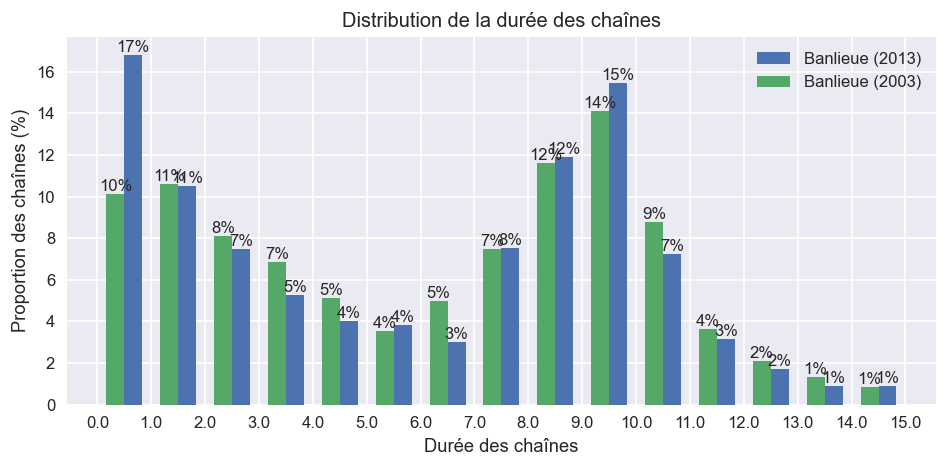

In [246]:
width = 20
plt.figure(figsize=(8, 4), dpi=120)
def length_plot(df, title, offset):
    df_chaine = df[df["f_chaine"] == 'T']

    total_facper = df_chaine.facper.sum()

    bin_edges = np.arange(0, 960, 60) # 0 to 900 minutes with 60 minute increments
    bins = np.histogram(list(df_chaine.ch_duree), bins=bin_edges, weights=df_chaine.facper / total_facper * 100)[0]

    print(len(bins))
    bar = plt.bar(bin_edges[:-1]+60/2-offset, bins, width=width, label=title)
    plt.bar_label(bar, fmt="%.0f%%")

    _ = plt.xticks(bin_edges, bin_edges/60)
    plt.xlabel("Durée des chaînes")
    plt.ylabel("Proportion des chaînes (%)")
    plt.title("Distribution de la durée des chaînes")
length_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
length_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.tight_layout()
plt.legend()




63.82704630705559
61.89061574187979


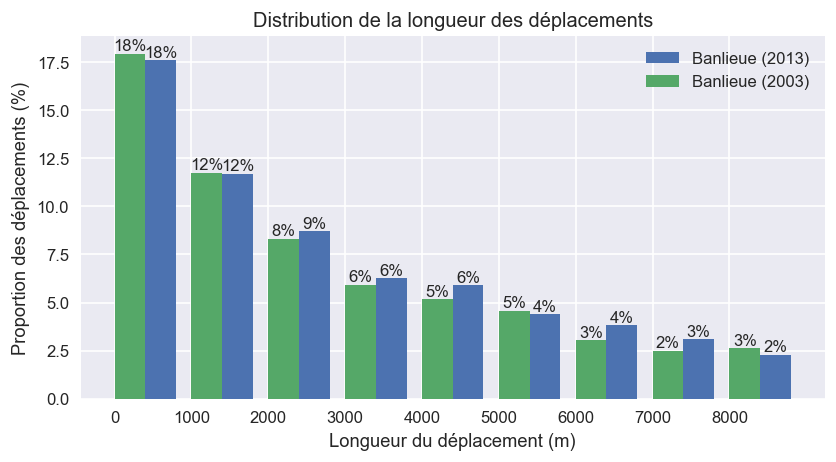

In [304]:
width = 400
plt.figure(figsize=(8, 4), dpi=120)
def dist_plot(df, title, offset):
    total_facper = df.facper.sum()

    bin_edges = np.arange(0, 10 * 1000, 1000)
    bins = np.histogram(list(df.distance_meters), bins=bin_edges, weights=df.facper / total_facper * 100)[0]
    print(sum(bins))
    bar = plt.bar(bin_edges[:-1]+width-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Longueur du déplacement (m)")
    plt.ylabel("Proportion des déplacements (%)")
    plt.title("Distribution de la longueur des déplacements")
dist_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
dist_plot(suburb_2003, title="Banlieue (2003)", offset=width/2)
plt.legend()




349
205


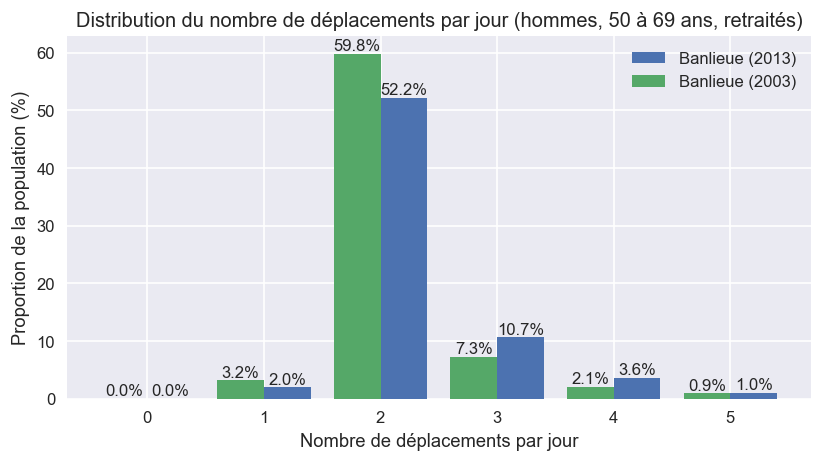

In [270]:
width = 0.4
plt.figure(figsize=(8, 4), dpi=120)
def n_depl_plot(df, title, offset):
    df_pers = df[(df.f_pers == 'T')
               & (df.genre == 1) 
               & (df.age >= 50) 
               & (df.age <= 69)
               & (df.p_statut == 4)]
    print(len(df_pers))

    total_faclog = df_pers.facper.sum()

    bin_edges = np.array([0, 1, 2, 3, 4, 5, 6])
    bins = np.histogram(list(df_pers.nb_depl), bins=bin_edges, weights=df_pers.facper / total_faclog * 100)[0]
    
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.1f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Nombre de déplacements par jour")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Distribution du nombre de déplacements par jour (hommes, 50 à 69 ans, retraités)")
n_depl_plot(suburb_2013, title="Banlieue (2013)", offset=-width/2)
n_depl_plot(suburb_2003, title="Banlieue (2003)", offset=+width/2)
plt.legend()



# Tâche 3

189
91.4485085577902
61
94.76606615948792
76
91.55684938835194


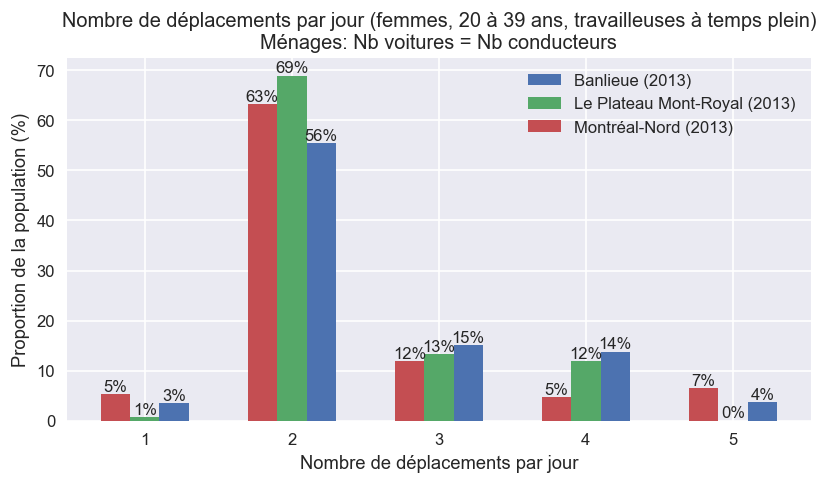

In [323]:
width = 0.2
plt.figure(figsize=(8, 4), dpi=120)
def _n_depl_plot(df, title, offset):
    df_pers = pers_typology(df, 2)
    df_pers = df_pers[df_pers.f_pers == "T"]
    #df_pers = neighborhood_typology(df_pers, 4)
    df_pers = menages_typology(df_pers, 3)
    print(len(df_pers))

    total_faclog = df_pers.facper.sum()

    bin_edges = np.array([1, 2, 3, 4, 5, 6])
    bins = np.histogram(list(df_pers.nb_depl), bins=bin_edges, weights=df_pers.facper / total_faclog * 100)[0]

    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Nombre de déplacements par jour")
    plt.ylabel("Proportion de la population (%)")
    plt.title("Nombre de déplacements par jour (femmes, 20 à 39 ans, travailleuses à temps plein)\nMénages: Nb voitures = Nb conducteurs")
_n_depl_plot(suburb_2013, title="Banlieue (2013)", offset=-width)
_n_depl_plot(plateau, title="Le Plateau Mont-Royal (2013)", offset=0)
_n_depl_plot(montrealNord, title="Montréal-Nord (2013)", offset=+width)
plt.legend()




189
61
76


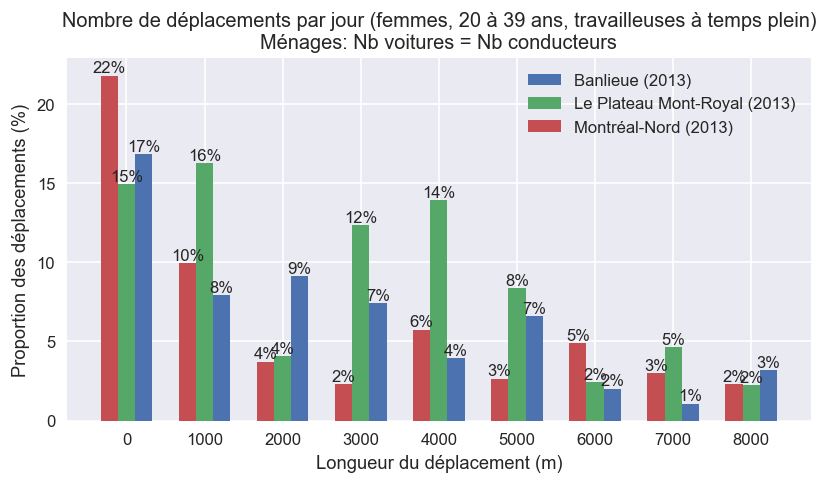

In [337]:
width = 220
plt.figure(figsize=(8, 4), dpi=120)
def _n_dist_plot(df, title, offset):
    df_pers = pers_typology(df, 2)
    df_pers = df_pers[df_pers.f_pers == "T"]
    #df_pers = neighborhood_typology(df_pers, 4)
    df_pers = menages_typology(df_pers, 3)
    print(len(df_pers))

    total_facper = df_pers.facper.sum()

    bin_edges = np.arange(0, 10 * 1000, 1000)
    bins = np.histogram(list(df_pers.distance_meters), bins=bin_edges, weights=df_pers.facper / total_facper * 100)[0]
    bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    #bar = plt.bar(bin_edges[:-1]-offset, bins, width=width, align="center", label=title)
    plt.bar_label(bar, fmt="%.0f%%")
    _ = plt.xticks(bin_edges[:-1])
    plt.xlabel("Longueur du déplacement (m)")
    plt.ylabel("Proportion des déplacements (%)")
    plt.title("Nombre de déplacements par jour (femmes, 20 à 39 ans, travailleuses à temps plein)\nMénages: Nb voitures = Nb conducteurs")
_n_dist_plot(suburb_2013, title="Banlieue (2013)", offset=-width)
_n_dist_plot(plateau, title="Le Plateau Mont-Royal (2013)", offset=0)
_n_dist_plot(montrealNord, title="Montréal-Nord (2013)", offset=+width)
plt.legend()
